# INTRODUCTION

In this notebook there is the implementation of the ZOO evasion attack, BadNets backdoor poisoning attack and Clean-label black-box attack done on a traffic sign recognition CNN

# TRAFFIC SIGN RECOGNITION CNN

Here we will implement in python using tensorflow a convolutional neural network created for traffic sign recognition.

We will recreate a CNN using the architecture and dataset described in this paper https://link.springer.com/article/10.1007/s11042-022-12531-w

We will use only GTSRB dataset which is a German Traffic Sign dataset used to train, validate and test out CNN.

First import the dataset into the python code

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt

Check if Tensorflow is using GPU or CPU

In [2]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9672987917938866379]

now we read train images and their labels from GTSRB dataset.

In this dataset there are 43 classes of traffic signs. In the "train" folder we have folder numerated from 0 to 42. In the folder <i>d</i> there are all images of signs associated to label <i>d</i>.

Dataset took from https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign?resource=download

<b>YOU CAN LOAD THE DATASET FROM THE "DATASET IMAGES" FOLDER USING THESE INSTRUCTIONS</b>

In [3]:
from PIL import Image
import os
import numpy as np

def load_dataset(path):
    data = []
    labels = []
    classes = 43
    
    
    
    #Retrieving the images and their labels
    for i in range(classes):
        pt = os.path.join(path,str(i))
        images = os.listdir(pt)
    
        for a in images:
            try:
                image = Image.open(pt + '/'+ a)
                image = image.resize((32,32))
                image = np.array(image)
    
                #data.append(image)
                #labels.append(i)
                data.append([image,i]) #appending all value together
            except:
                print("Error loading image")
    return data

In [4]:
data=load_dataset("./Dataset Images")

All images are resized in order to be a 32x32px images

now we create the dataset of images

In [5]:
X=[]
y=[]

for features,target in data:
  X.append(features)
  y.append(target)

Divide the dataset into validation and train dataset, respectivel 70% train as said into the paper

In [6]:
from sklearn.model_selection import train_test_split
#Converting lists into numpy arrays
X = np.array(X)
y = np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape,y_train.shape)

(27446, 32, 32, 3) (27446,)


<b>OR LOAD THE DATASET FROM NUMPY FILES</b>

In [7]:
X_train = np.load('./Dataset Numpy/X_train.npy', allow_pickle=True)
y_train = np.load('./Dataset Numpy/y_train.npy', allow_pickle=True)
X_val = np.load('./Dataset Numpy/X_val.npy', allow_pickle=True)
y_val = np.load('./Dataset Numpy/y_val.npy', allow_pickle=True)

print(X_train.shape,y_train.shape)

So we have 39209 images all of them are tensors 30x30x3 so with 3 channels (representing red, green and blue).

We use 27446 of them as training set.

Let's now scale features in order to have values not between 0 and 255 in tensors but between 0 and 1.

In [8]:
X_train=X_train/255.0
X_val=X_val/255.0

Let's not create the convolutional neural network as expressed in the paper

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), activation="relu",input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation="relu",input_shape=(28, 28, 32)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu",input_shape=(13, 13, 32)),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu",input_shape=(13, 13, 64)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),  #converts tensor into 1d vector
    tf.keras.layers.Dense(units=43,activation=tf.keras.activations.softmax)
])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
__________

Now let's train the model as done in the paper, by using a cross-entropy loss and Adam optimizer (with learning rate of 0.001) as algorithm to minimize the loss and a batch size of 128.

We use 5 epochs to train our NN and use the training dataset for train and for each epoch, track the performance on the validation dataset (using accuracy, precision and recall as metrics) in order to see how well the model performs on unseen data

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=['accuracy'])

In [10]:
history=model.fit(X_train,y_train,batch_size=128,epochs=10,validation_data=(X_val,y_val))

Train on 27446 samples, validate on 11763 samples
Epoch 1/10
27446/27446 [==============================]27446/27446 [==============================] - 21s 749us/step - loss: 1.5969 - acc: 0.5690 - val_loss: 0.3297 - val_acc: 0.9119

Epoch 2/10
27446/27446 [==============================]27446/27446 [==============================] - 20s 731us/step - loss: 0.2613 - acc: 0.9263 - val_loss: 0.1193 - val_acc: 0.9711

Epoch 3/10
27446/27446 [==============================]27446/27446 [==============================] - 20s 716us/step - loss: 0.1291 - acc: 0.9637 - val_loss: 0.0725 - val_acc: 0.9829

Epoch 4/10
27446/27446 [==============================]27446/27446 [==============================] - 20s 716us/step - loss: 0.0780 - acc: 0.9775 - val_loss: 0.0448 - val_acc: 0.9896

Epoch 5/10
27446/27446 [==============================]27446/27446 [==============================] - 19s 709us/step - loss: 0.0587 - acc: 0.9839 - val_loss: 0.0376 - val_acc: 0.9901

Epoch 6/10
27446/27446 [======

Trained our model we wil save it on a file

In [11]:
model.save_weights("Model.weights_zoo.h5")

<b>TO IMPORT WEIGHTS USED IN THIS EXPERIMENTATION, EXECUTE THE FOLLOWING CELL</b>

In [10]:
model.load_weights("Model.weights_zoo.h5")

# MODEL'S PERFORMANCES

Once trained the neural network we print what the model output looks like

In [11]:
sample = X_val[0].reshape((1,32,32,3))
output=model.predict(sample)

print("NN output:",output)
print("Real label associated to the sample:",y_val[0])

NN output: [[3.2535488e-09 9.2311922e-11 2.1966640e-08 5.5536728e-14 3.2813823e-05
  6.1875161e-10 1.1985805e-18 1.6393782e-14 8.6052836e-08 1.3134155e-06
  3.0988534e-10 3.5597734e-09 1.7069027e-14 1.2488455e-12 1.2302780e-14
  3.1822174e-07 2.4892423e-11 9.0165376e-16 3.4888578e-07 1.4202342e-06
  2.8985127e-08 3.5715087e-07 2.4893967e-09 4.9101168e-11 6.3820489e-06
  4.4792842e-10 9.9995661e-01 2.3928914e-10 1.4132603e-09 1.5216507e-07
  9.2167214e-13 9.2814591e-14 3.7410901e-14 9.7441129e-15 5.4902750e-23
  7.5574685e-14 6.7361812e-13 1.1494199e-16 7.7419478e-13 9.0291739e-15
  6.4540401e-08 1.6789403e-14 5.3735891e-19]]
Real label associated to the sample: 26


So the NN since implement a softmax output layer, output a vector of 43 elements in which the $j$-the element represent the probability that $x$ is classified as label $j$.

So now we implement a function that given this vector, returns the heighest probability and the label class with the highest probability.


In [11]:
def out_label(prob_vector):
  max_proba=max(prob_vector)
  predicted_label,=np.where(prob_vector==max_proba)
  return max_proba, predicted_label[0]

Now let's see if the previous prediction was correct

In [12]:
highest_proba, predicted_label=out_label(output[0])
print("NN output label:",predicted_label,"with a probability of:",highest_proba)
print("Real label associated to the sample:",y_val[0])

NN output label: 26 with a probability of: 0.9995208
Real label associated to the sample: 26


Good, the NN works. Let's now test it on the validation dataset and see the performance of the network in terms of:<br>
- Accuracy<br>
$\frac{TP+TN}{TP+FP+TN+FN}$
- Precision<br>
$\frac{TP}{TP+FP}$<br>
Precision for class $j$ represent the probability that a sample classified as $j$ is effectively labeled as $j$.
- Recall<br>
$\frac{TP}{TP+FN}$<br>
Recall for class $j$ represent the probability that the model correctly classify as $j$ a sample labeled with $j$.

In [140]:
def evaluate_model(model, X_test, y_test):
    predicted_labels=[]

    output=model.predict(X_test)

    for o in output:
        highest_proba, predicted_l=out_label(o)
        predicted_labels.append([predicted_l])

    predicted_labels=np.array(predicted_labels)
    y_test=np.array([[y] for y in y_test])

    #now we got the vector of predicted labels for each of the samples in the validation dataset
    #calculate the accuracy
    accuracy=(y_test == predicted_labels).sum() / X_test.shape[0]

    #let's now calculate precision and recall which refers to single classes
    precisions=[]
    recalls=[]

    for label in range(43):
        y_true=np.where(y_test==[label],1,0)
        y_pred=np.where(predicted_labels==[label],1,0)

        TP = np.count_nonzero(y_pred * y_true)
        TN = np.count_nonzero((y_pred - 1) * (y_true - 1))
        FP = np.count_nonzero(y_pred * (y_true - 1))
        FN = np.count_nonzero((y_pred - 1) * y_true)

        #calculate precision
        precision_metric= TP / (TP + FP)
        precisions.append(precision_metric)

        #calculate recall
        recall_metric= TP / (TP + FN)
        recalls.append(recall_metric)

    return accuracy,np.array(precisions),np.array(recalls)

In [145]:
acc,precisions,recalls=evaluate_model(model,X_val,y_val)

In [146]:
print("Models metrics on validation set are:")
print("Accuracy:",acc)
print("Average precision:",np.average(precisions))
print("Average recall:",np.average(recalls))
print("\n")
print('| {:^10} | {:^10} | {:^10} |'.format(*["Class","Precision","Recall"]))
for p in range(43):
  r=recalls[p]
  pr=precisions[p]
  print('| {:^10} | {:^10.2f} | {:^10.2f} |'.format(*[p,pr,r]))

Models metrics on validation set are:
Accuracy: 0.9923488905891354
Average precision: 0.9931323982836833
Average recall: 0.989496958372078


|   Class    | Precision  |   Recall   |
|     0      |    1.00    |    0.89    |
|     1      |    0.98    |    1.00    |
|     2      |    1.00    |    0.98    |
|     3      |    1.00    |    0.99    |
|     4      |    0.99    |    1.00    |
|     5      |    0.99    |    0.98    |
|     6      |    1.00    |    0.99    |
|     7      |    0.98    |    1.00    |
|     8      |    0.99    |    0.98    |
|     9      |    0.99    |    1.00    |
|     10     |    1.00    |    1.00    |
|     11     |    0.99    |    0.99    |
|     12     |    1.00    |    1.00    |
|     13     |    1.00    |    1.00    |
|     14     |    1.00    |    1.00    |
|     15     |    0.99    |    1.00    |
|     16     |    1.00    |    1.00    |
|     17     |    1.00    |    0.99    |
|     18     |    0.98    |    1.00    |
|     19     |    0.98    |    0.96    

Let's now plot the accuracy and the loss on train and validaton dataset uring each epoch in the training process.

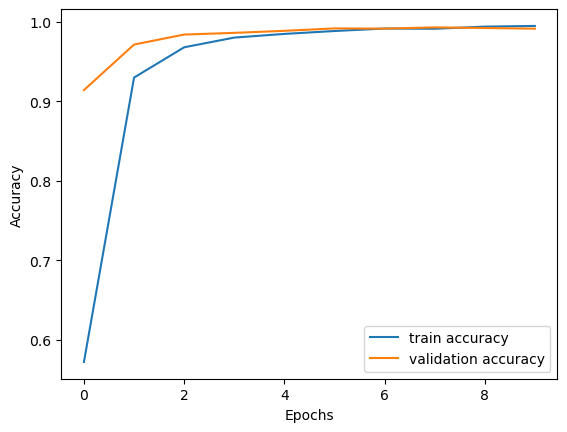

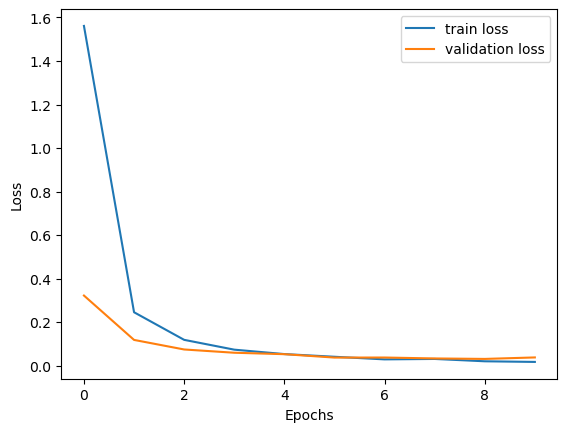

In [17]:
plt.plot(range(10), history.history["accuracy"], label="train accuracy")
plt.plot(range(10), history.history["val_accuracy"], label="validation accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

plt.plot(range(10), history.history["loss"], label="train loss")
plt.plot(range(10), history.history["val_loss"], label="validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# ZOO (ZEROTH-ORDER OPTIMIZATION)

The evasion attack that we are going to implement on the model is calld zeroth-order optimization attack, a black-box evasion targeted attack that plans to generate adversarial examples.

Our sperimentation focus on stop signs, which has class number 14 on the GTSRB dataset.

Our goal is to create adversarial examples for stop signs (class 14) in order to let the model classify them as 50 speed limit signs (class 2).

In order to do this we can take an example $x$ of stop sign from which start creating our first adversarial example $x'$ by using zeroth-order optimization.

This attack plans to find the adversarial example $x'$ such that solves this minimization problem:<br>
$\min_{x'} ||x-x'||_2^2+λ*f(x',t)$<br>
With $x$ the example on which we are basing, $λ$ a regularization parameter, $t$ the target class that in our case is class 2 (50 speed limit signs) and $f(x',t)$ which is a function that represent the probability of attack's failure.

The function $||x'-x||_2^2$ represent the distance between the example $x$ and the adversarial exmaple $x'$.

So by solving the minimization problem we find an adversarial example such that the difference between it and $x$ is minimum and the probability of unsuccess of the attack is also minimum.

The function $f$ is defined as follows:<br>
$f(x',t)=\max \{\max_{i\neq t} \log(a_i^{(x')}) -\log(a_t^{(x')}),-k\}$<br>
With $a_j^{(x')}$ the probability that example $x'$ is classified as $y=j$ and so $a_j^{(x')}=P(y=j|x')$.<br>
The term $k$ is another constant that ensures a constant gap between $\max_{i\neq t} \log(a_i^{(x')})$ and $\log(a_t^{(x')})$.

The evasion attack success if the model misclassify an adversarial example as 50 speed limit sign.
<br><br>
In order to solve this optimization problem we use gradient optimization algorthim which plans to compute derivatives of the objective function in order to update parameter $x$ until its value become closer enought to the minimum $x'$.

Since we do not know the explicit formula of $a_j^{(x)}$, since it's an internal information to the NN and being in a black-box attack we do not have access to it, we are going to approximate the value of the derivative of $f$ by using the simmetric diference quotient as follows:<br>
$\hat{g_i}:=\frac{∂f}{∂x_i}(x)≈\frac{f(x+he_i)-f(x-he_i)}{2h}$<br>
With $h$ a small constat value, and $e_i$ the basis vector that has all zeros and only 1 at $i$-th position.

Let's start implementing some functions that we need in order to perform this attack.

Find examples to generate adversarial examples.

As examples we will take images classified as a stop sign with the lowest probability among all images classified as stop signs.

In [12]:
def find_lowest_class_probabile_images(X,y,model,label,n):
  '''
  Find first n images classified as label "label" with the lowest probabilty
  
  returns the vector of the first n images and relative probabilities, classified as "label" with the lowest probabilty
  (ex. [{"proba":0.97,"image":...},...])
  '''
  model_predictions_label=[]

  #calculate probabilities for all images
  probs=model.predict(X)

  #for all preditions
  for i in range(probs.shape[0]):
    #get ouput label
    highest_proba, predicted_label=out_label(probs[i])

    #if the output label is "label"
    if predicted_label==label:
      #store the image and predicted probability of its
      model_predictions_label.append({"proba":highest_proba,"image":X[i]})
  
  #order the array of images classified as stop signs from the lowest probability to the hightest
  ordered_predictions=sorted(model_predictions_label, key=lambda d: d['proba'])

  #return first n elements of this array
  return ordered_predictions[:n]

Get the 500 samples classified as stop signs with the lowerst probability

Image probability: 0.6150221


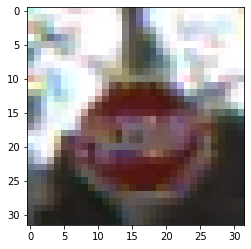

In [13]:
#get first 20 images classified as stop signs with the lowest probability among validation dataset
lowest_prob_images_stop_sign=find_lowest_class_probabile_images(X_val,y_val,model,14,500)

#print the image classified as stop sign with the lowest probability
print("Image probability:",lowest_prob_images_stop_sign[0]["proba"])
plt.imshow(lowest_prob_images_stop_sign[0]["image"])
plt.show()

That's the image of a stop sign that is classified as a stop sign with the lowest probability.

We will use these images as beginner samples in order to create our adversarial examples using zeroth-order optimization attack.

# ZOO ATTACK UNTARGETED

Install library for adverarial attacks

In [14]:
import Autozoomattack.Utils as util
from Autozoomattack.blackbox_attack import ZOO
from numpy import linalg as LA

Define the model

In [15]:
class Modello:
    def __init__(self, model):
        self.num_channels = 3
        self.image_size = 32
        self.num_labels = 43

        self.model=model


    def predict(self, data):
        return self.model(data)

Define images to use in order to generate adversarial examples

In [16]:
#take images classified as stop sign with the lowest probability
#they will be the images from which adv images will be generated
imgs_to_adv=[i["image"] for i in lowest_prob_images_stop_sign][:100]

Perform the attack

In [ ]:
#list which contains all adv examples
advs=[]

with tf.Session() as sess:
    #initialize variables (prevent FailedPreconditionError error)
    init_op = tf.initialize_all_variables()
    sess.run(init_op)
    
    model.load_weights("Model.weights_zoo.h5")
    
    mod=Modello(model)

    args={"batch_size":128,"img_resize":20,"max_iterations":1500,"print_every":1000,"switch_iterations":100,
         "init_const":0.1,"attack_type":"untargeted","use_tanh":False,"lr":2e-3,"confidence":0.0}
    
    blackbox_attack = ZOO(sess,mod,args)

    labelss=np.zeros(43)
    labelss[14]=1  #one-hot encoded label
    
    
    #cicle through all examples
    for i in imgs_to_adv:
        adv = blackbox_attack.attack(i,labelss)
                
        advs.append(adv)
        
    
    advs=np.array(advs, dtype=float)

Create a function which resume the attack results on one figure

In [18]:
def show_images_adv_pred(imgs,x,y,save,file_name):
    '''
    Function which shows a figure with all adversarial images it's:
    - stop sign probability
    - predicted label's probability
    - norm of the difference between the adversarial image and the original one
    
    imgs: images to show
    x:width of the figure
    y:hieght of the figure
    save: true if you want to save the figure
    file_name: path to which save the figure if "save" is true
    '''
    # create figure 
    fig = plt.figure(figsize=(x, y)) 
    fig.patch.set_facecolor('xkcd:white')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.1, 
                    top=1.7, 
                    wspace=0.4, 
                    hspace=0.4)

    # setting values to rows and column variables 
    rows = int(np.sqrt(imgs.shape[0]))+1
    columns = int(np.sqrt(imgs.shape[0]))+1
    
    for i in range(1,imgs.shape[0]+1):
        # Adds a subplot at the ith position 
        fig.add_subplot(rows, columns, i) 

        # showing image 
        plt.imshow(imgs[i-1]["image"].reshape((32,32,3))) 
        plt.axis('off') 
        plt.title(str(imgs[i-1]["real_label"])+"→"+str(imgs[i-1]["predicted_label"])+
                  "\n Label "+str(imgs[i-1]["predicted_label"])+" Prob: "+
                 str(round(imgs[i-1]["predicted_proba"],3))+"\n Stop Sign Prob: "+str(round(imgs[i-1]["stop_sign_proba"],3))+
                 "\n L2 Norm: "+str(round(imgs[i-1]["difference"],3)))

    if save:
        plt.savefig(file_name+'.png',bbox_inches='tight')

Calculate success rate and average norm of the difference between adv images and original images. Then show the figure with all adv images generated

Success rate= 0.97
avg_norm= 7.934832282904268
Model's Predictions on adversarial examples
True Label->Predicted Label


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


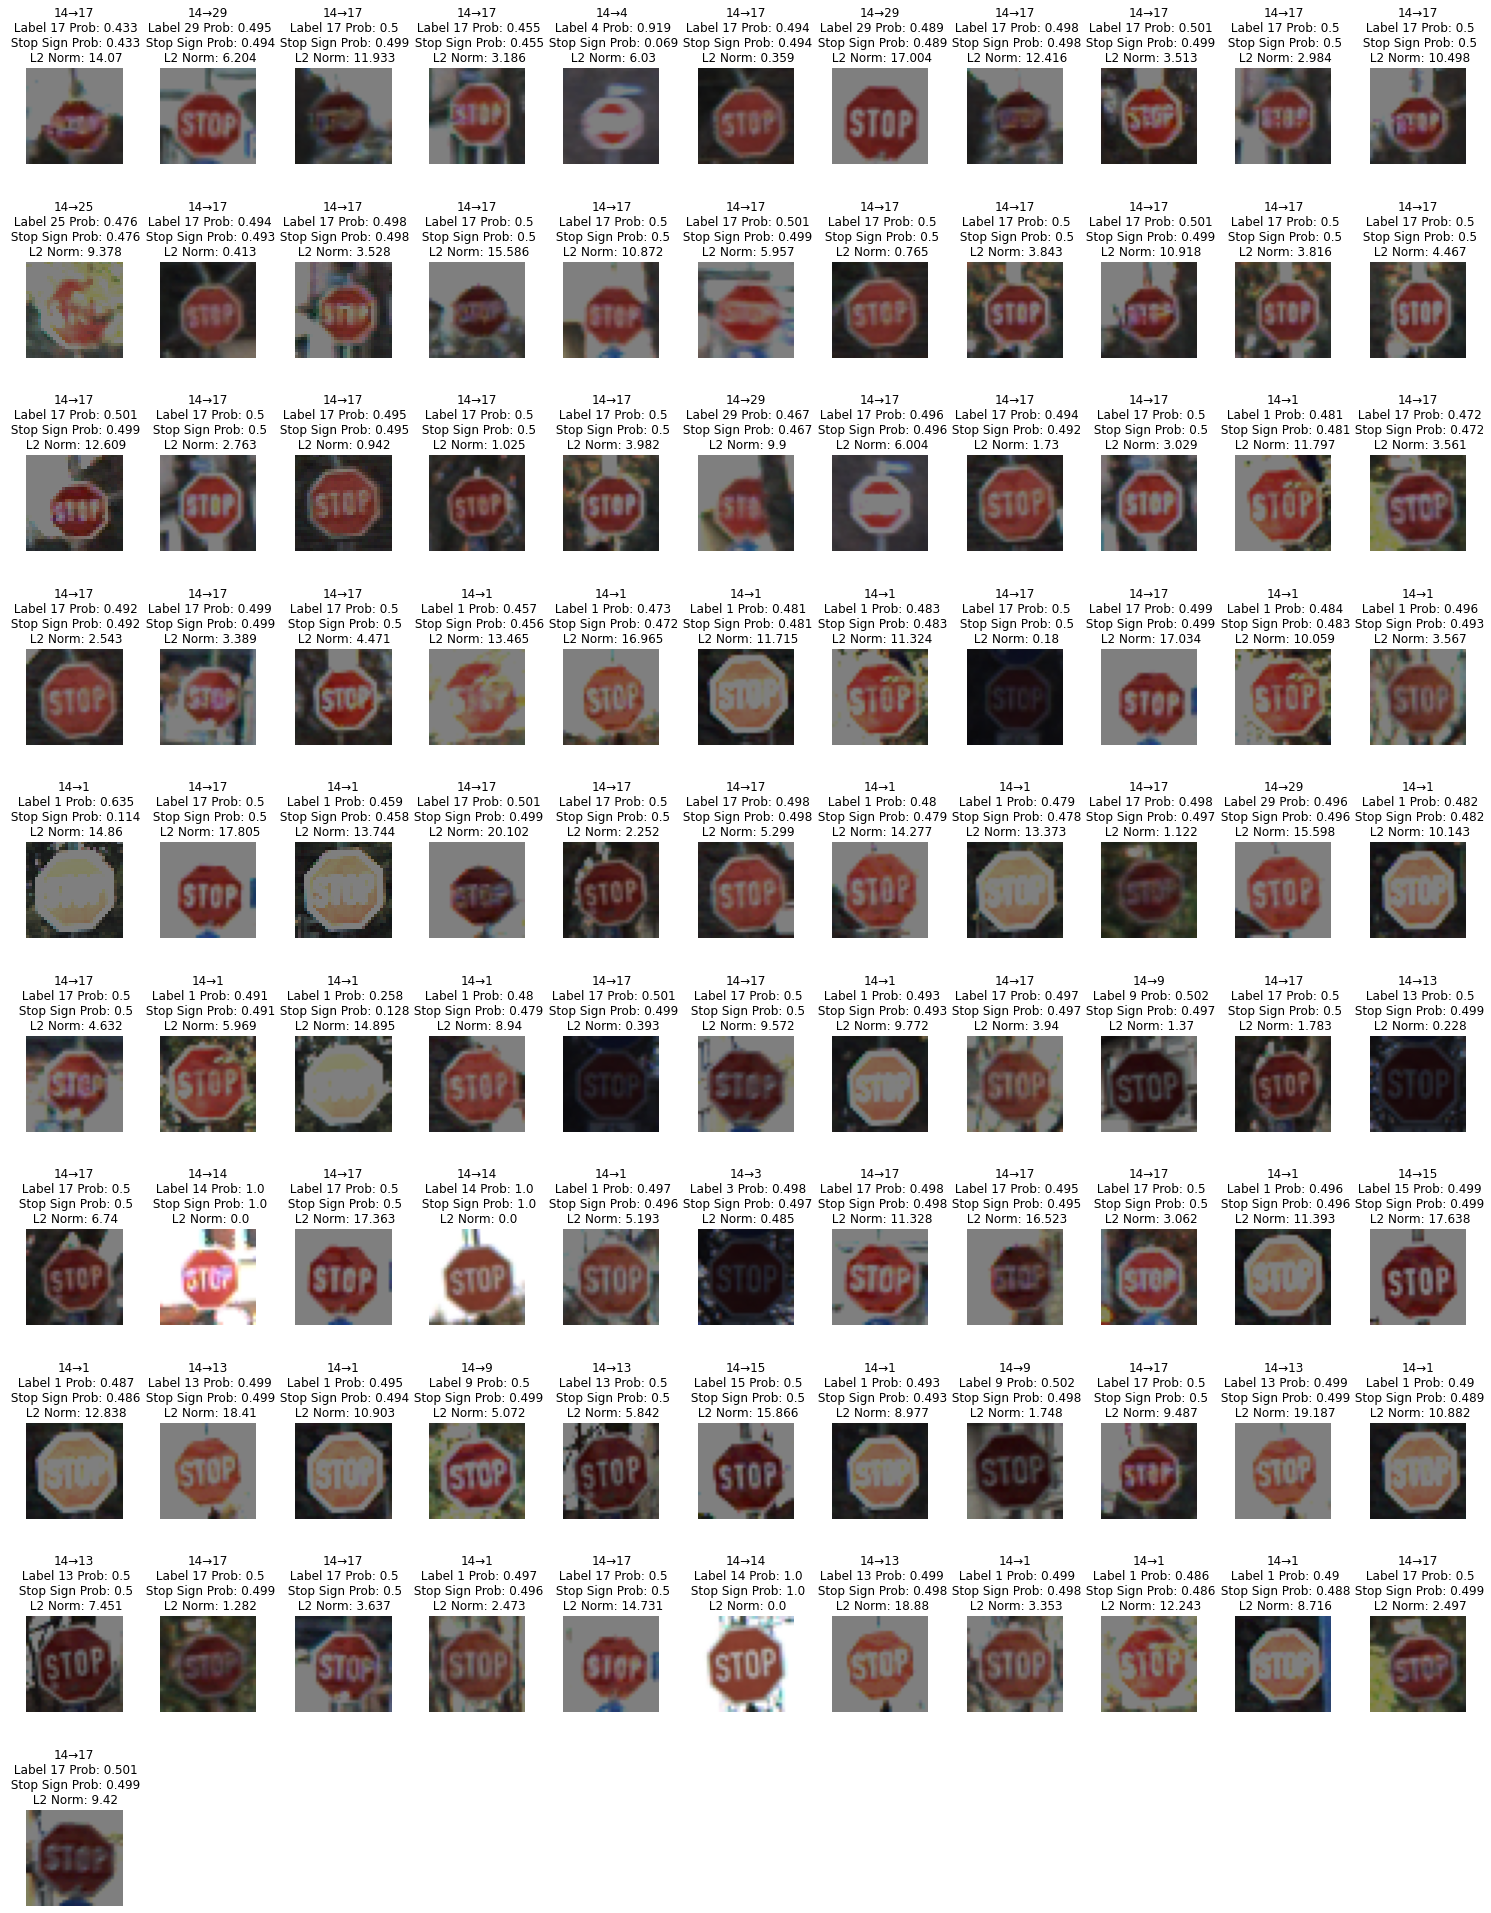

In [54]:
#calculate norm and success rate
#calculate model's predictions for adversarial examples
pred_vector_adv=mod.model.predict(advs)

#get predicted label
pred_labels_adv=np.array([np.argmax(p) for p in pred_vector_adv])

#get number of adv samples not predicted as stop signs
success_advs=len([p for p in pred_labels_adv if p!=14])

#calculate success rate
success_rate=success_advs/pred_labels_adv.shape[0]

#calculate average norm
avg_norm=np.average(np.array([LA.norm(advs[i].ravel()-imgs_to_adv[i].ravel(),2) for i in range(advs.shape[0])]))

#return difference between success rate and avg norm 
#output is maximum when avg->0 and success_rate->1

print("Success rate=",success_rate)
print("avg_norm=",avg_norm)


#print img
pred_imgs_adv=[]


for i in range(pred_vector_adv.shape[0]):
    #calculate predicted label
    label_pred_adv = np.argmax(pred_vector_adv[i])

    #calulate predicted label proba
    prob_pred_adv = np.max(pred_vector_adv[i])

    #calculate stop sign proba
    stop_sign_proba = pred_vector_adv[i][14]

    #calculate norm l2 of the difference between adversarial example and original example
    diff=LA.norm(advs[i].ravel()-imgs_to_adv[i].ravel(),2)

    pred_imgs_adv.append({"image":advs[i],"predicted_label":label_pred_adv,"real_label":14,
                          "predicted_proba":prob_pred_adv,"stop_sign_proba":stop_sign_proba,"difference":diff})

print("Model's Predictions on adversarial examples")
print("True Label->Predicted Label")
show_images_adv_pred(np.array(pred_imgs_adv),20,18,False,"")

Save generated adversarial examples

In [ ]:
#save images in txt by saving the arrays that represents the images as string byte in the txt file
np.save('imgs.npy', advs, allow_pickle=True)

# ZOO TARGETED

Define images to use in order to generate adversarial examples

In [163]:
#take images classified as stop sign with the lowest probability
#they will be the images from which adv images will be generated
imgs_to_adv=[i["image"] for i in lowest_prob_images_stop_sign][:100]

Perform the attack

In [ ]:
#list which contains all adv examples
advs=[]

target_label=8

with tf.Session() as sess:
    #initialize variables (prevent FailedPreconditionError error)
    init_op = tf.initialize_all_variables()
    sess.run(init_op)
    
    model.load_weights("Model.weights_zoo.h5")
    
    mod=Modello(model)

    args={"batch_size":128,"img_resize":32,"max_iterations":6000,"print_every":1000,"switch_iterations":100,
         "init_const":0.001,"attack_type":"targeted","use_tanh":False,"lr":5e-4,"confidence":0.0}
    
    blackbox_attack = ZOO(sess,mod,args)

    labelss=np.zeros(43)
    labelss[target_label]=1  #one-hot encoded target label (target label=8)
    
    
    #cicle through all examples
    for i in imgs_to_adv:
        adv = blackbox_attack.attack(i,labelss)
                
        advs.append(adv)
        
    
    advs=np.array(advs, dtype=float)

Calculate success rate and average norm of the difference between adv images and original images. Then show the figure with all adv images generated

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Success rate= 0.98
avg_norm= 8.396305599118431
Model's Predictions on adversarial examples
True Label->Predicted Label


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

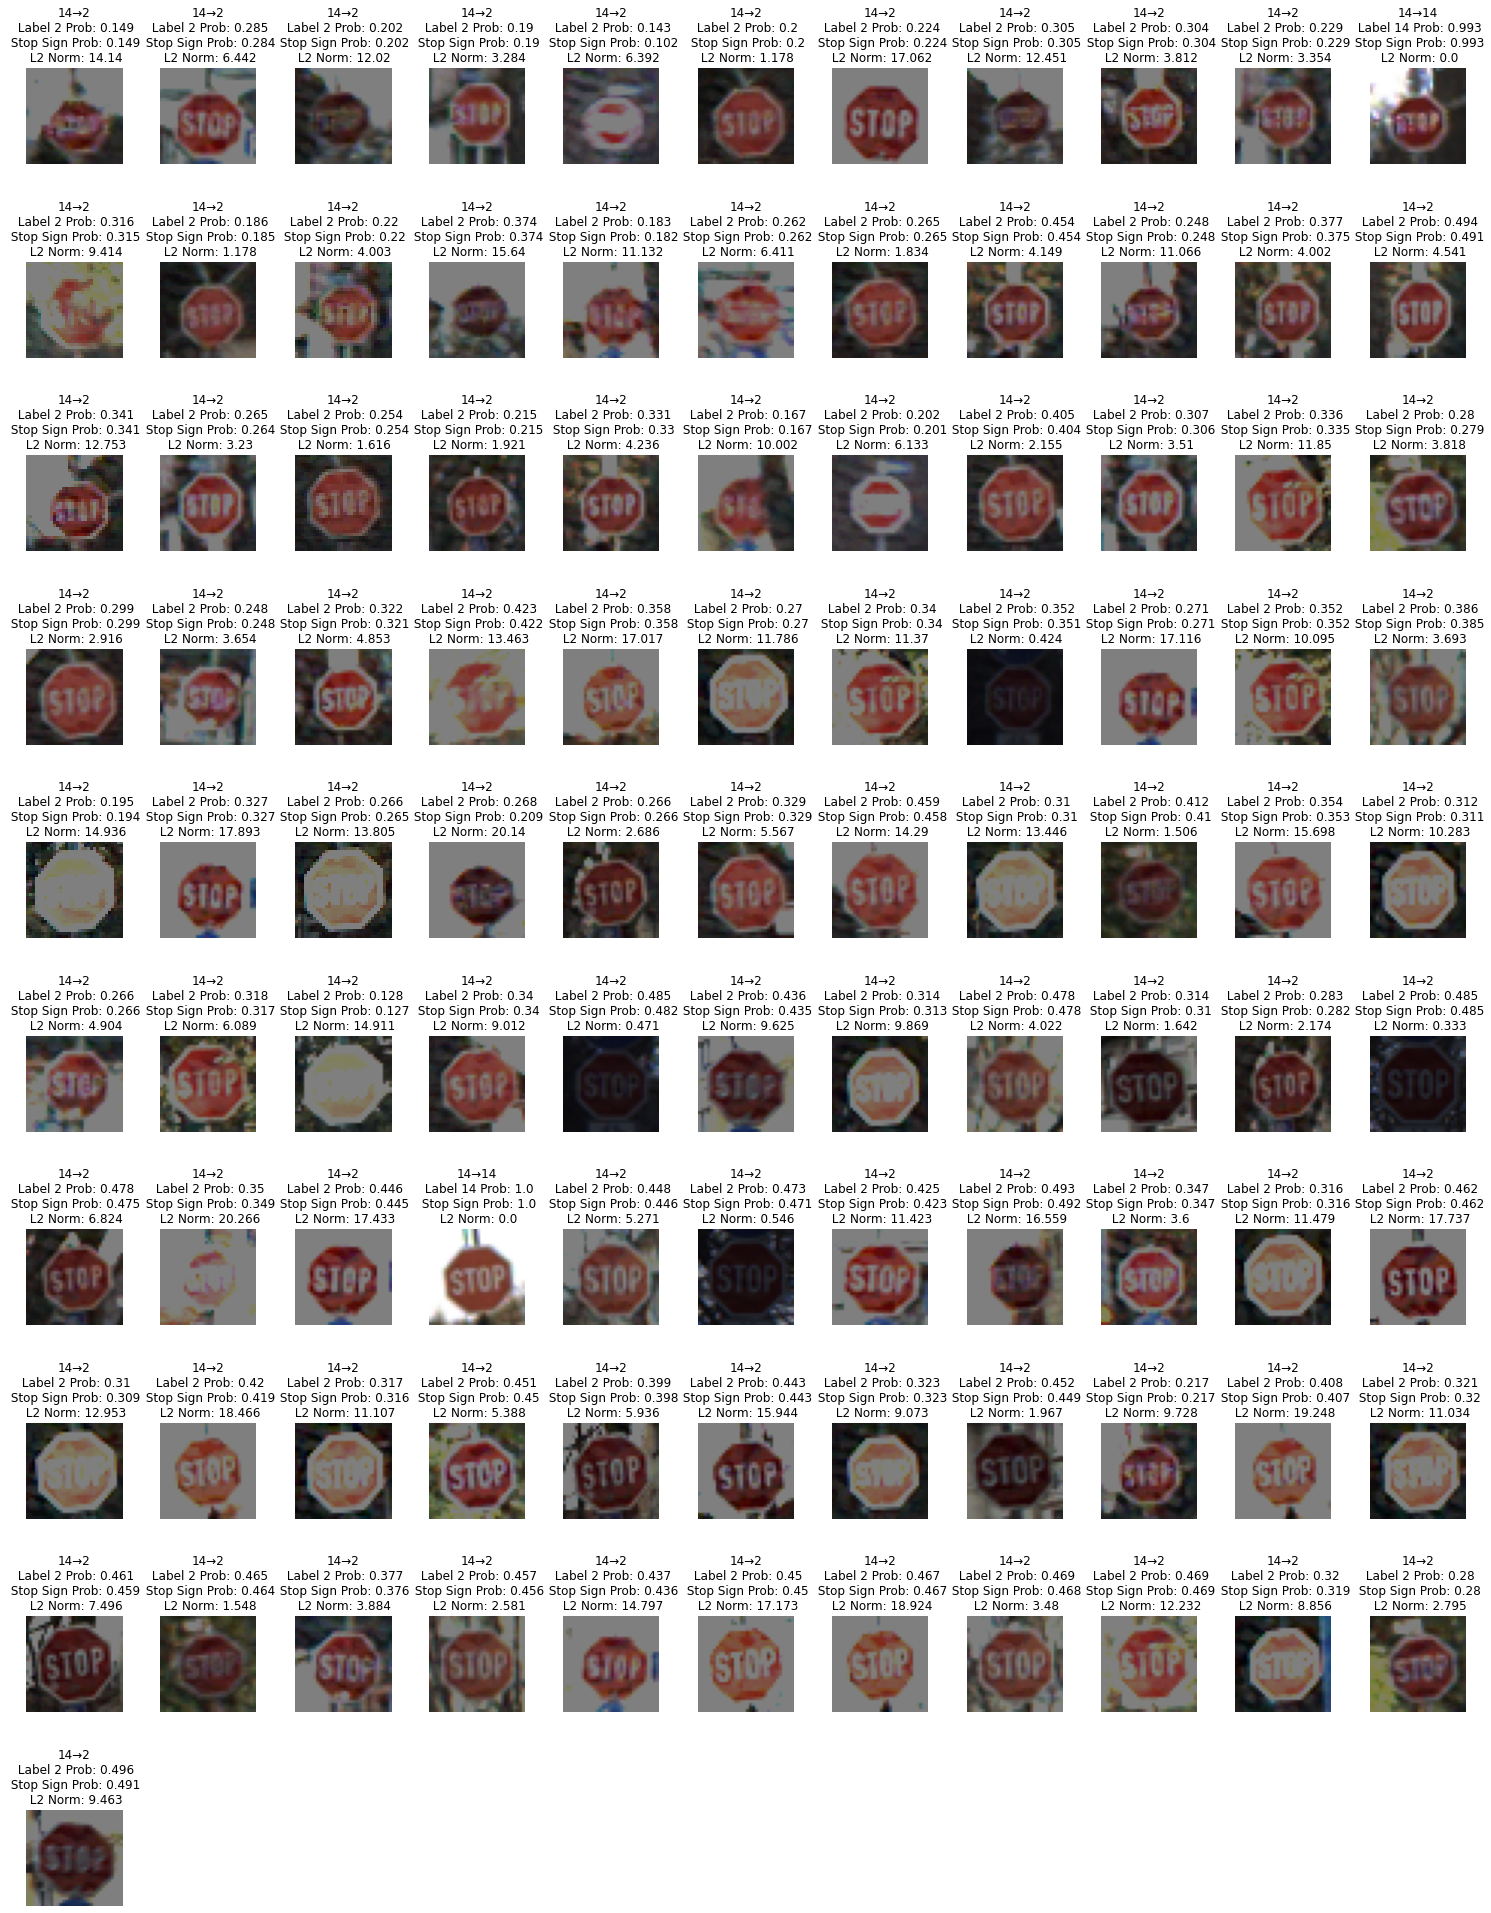

In [36]:
#calculate norm and success rate
#calculate model's predictions for adversarial examples
pred_vector_adv=mod.model.predict(advs)

#get predicted label
pred_labels_adv=np.array([np.argmax(p) for p in pred_vector_adv])

#get number of adv samples predicted as the target label
success_advs=len([p for p in pred_labels_adv if p==target_label])

#calculate success rate
success_rate=success_advs/pred_labels_adv.shape[0]

#calculate average norm
avg_norm=np.average(np.array([LA.norm(advs[i].ravel()-imgs_to_adv[i].ravel(),2) for i in range(advs.shape[0])]))

#return difference between success rate and avg norm 
#output is maximum when avg->0 and success_rate->1

print("Success rate=",success_rate)
print("avg_norm=",avg_norm)


#print img
pred_imgs_adv=[]


for i in range(pred_vector_adv.shape[0]):
    #calculate predicted label
    label_pred_adv = np.argmax(pred_vector_adv[i])

    #calulate predicted label proba
    prob_pred_adv = np.max(pred_vector_adv[i])

    #calculate stop sign proba
    stop_sign_proba = pred_vector_adv[i][14]

    #calculate norm l2 of the difference between adversarial example and original example
    diff=LA.norm(advs[i].ravel()-imgs_to_adv[i].ravel(),2)

    pred_imgs_adv.append({"image":advs[i],"predicted_label":label_pred_adv,"real_label":14,
                          "predicted_proba":prob_pred_adv,"stop_sign_proba":stop_sign_proba,"difference":diff})

print("Model's Predictions on adversarial examples")
print("True Label->Predicted Label")
show_images_adv_pred(np.array(pred_imgs_adv),20,18,False,"")

Save adv images

In [ ]:
#save images in txt by saving the arrays that represents the images as string byte in the txt file
np.save('imgs.npy', advs, allow_pickle=True)

# BAYESIAN OPTIMIZATION FOR ZOO ATTACK

In [19]:
def zoo_performances_untargeted(c,confidence,lr):
    '''
    Function which conduct an untargeted zoo attack and returns a value which is: success rate - average norm fo the difference
    between adv and original examples, representing the performance of the attack
    
    c: initial_const parameter for ZOO attack
    confidence: confidece parameter for ZOO attack
    lr: learning_rate parameter for ZOO attack
    '''
    
    print("\n\nc=",c,"confidence=",confidence,"lr=",lr,"\n\n")
    
    #take first 100 images classified as stop sign with the lowest probability
    imgs_to_adv=[i["image"] for i in lowest_prob_images_stop_sign][:100]

    #list which contains all adv examples
    advs=[]

    with tf.Session() as sess:
        #initialize variables (prevent FailedPreconditionError error)
        init_op = tf.initialize_all_variables()
        sess.run(init_op)

        model.load_weights("Model.weights_zoo.h5")

        mod=Modello(model)

        args={"batch_size":128,"img_resize":32,"max_iterations":1500,"print_every":1000,"switch_iterations":100,
             "init_const":c,"attack_type":"untargeted","use_tanh":False,"lr":lr,"confidence":confidence}

        blackbox_attack = ZOO(sess,mod,args)

        labelss=np.zeros(43)
        labelss[14]=1  #one-hot encoded label


        #cicle through all examples
        for i in imgs_to_adv:
            adv = blackbox_attack.attack(i,labelss)

            advs.append(adv)


        advs=np.array(advs) 

    #generate adversarial examples
    x_test_adv = advs

    #calculate model's predictions for adversarial examples
    pred_vector_adv=mod.model.predict(x_test_adv)

    #get predicted label
    pred_labels_adv=np.array([np.argmax(p) for p in pred_vector_adv])

    #get number of adv samples not predicted as stop signs
    success_advs=len([p for p in pred_labels_adv if p!=14])

    #calculate success rate
    success_rate=success_advs/pred_labels_adv.shape[0]

    #calculate average norm
    avg_norm=np.average(np.array([LA.norm(x_test_adv[i].ravel()-imgs_to_adv[i].ravel(),2) for i in range(x_test_adv.shape[0])]))

    #return difference between success rate and avg norm 
    #output is maximum when avg->0 and success_rate->1


    #generate and save image of adv examples
    pred_imgs_adv=[]


    for i in range(pred_vector_adv.shape[0]):
        #calculate predicted label
        label_pred_adv = np.argmax(pred_vector_adv[i])

        #calulate predicted label proba
        prob_pred_adv = np.max(pred_vector_adv[i])

        #calculate stop sign proba
        stop_sign_proba = pred_vector_adv[i][14]

        #calculate norm l2 of the difference between adversarial example and original example
        diff=LA.norm(x_test_adv[i].ravel()-imgs_to_adv[i].ravel(),2)

        pred_imgs_adv.append({"image":x_test_adv[i],"predicted_label":label_pred_adv,"real_label":14,
                              "predicted_proba":prob_pred_adv,"stop_sign_proba":stop_sign_proba,"difference":diff})

    show_images_adv_pred(np.array(pred_imgs_adv),20,18,True,"./files/ZOO/bayesian_optimization/untargeted/adv_img_res/attack_c_"+str(c)+"_conf_"+str(confidence)+"_lr_"+str(lr))

    if avg_norm==0:
        result = -100
    else:
        #result = success_rate-avg_norm
        result = success_rate -(avg_norm/12)

    with open('./files/ZOO/bayesian_optimization/untargeted/results.txt', 'a+') as f:
        print("\n\nSuccess rate=",success_rate,file=f)
        print("avg_norm=",avg_norm,file=f)
        print("c=",c,"confidence=",confidence,"lr=",lr,"target=",result,"\n\n",file=f)

    return result

In [25]:
def zoo_performances_targeted(c,confidence,lr):
    '''
    Function which conduct an targeted zoo attack and returns a value which is: success rate - average norm fo the difference
    between adv and original examples, representing the performance of the attack
    
    c: initial_const parameter for ZOO attack
    confidence: confidece parameter for ZOO attack
    lr: learning_rate parameter for ZOO attack
    '''
    
    print("\n\nc=",c,"confidence=",confidence,"lr=",lr,"\n\n")
    
    #take first 100 images classified as stop sign with the lowest probability
    imgs_to_adv=[i["image"] for i in lowest_prob_images_stop_sign][:100]

    #list which contains all adv examples
    advs=[]
    
    target_label=8

    with tf.Session() as sess:
        #initialize variables (prevent FailedPreconditionError error)
        init_op = tf.initialize_all_variables()
        sess.run(init_op)

        model.load_weights("Model.weights_zoo.h5")

        mod=Modello(model)

        args={"batch_size":128,"img_resize":32,"max_iterations":4000,"print_every":1000,"switch_iterations":100,
         "init_const":0.001,"attack_type":"targeted","use_tanh":False,"lr":5e-4,"confidence":0.0}

        blackbox_attack = ZOO(sess,mod,args)

        labelss=np.zeros(43)
        labelss[target_label]=1  #one-hot encoded label


        #cicle through all examples
        for i in imgs_to_adv:
            adv = blackbox_attack.attack(i,labelss)

            advs.append(adv)


        advs=np.array(advs) 

    #generate adversarial examples
    x_test_adv = advs

    #calculate model's predictions for adversarial examples
    pred_vector_adv=mod.model.predict(x_test_adv)

    #get predicted label
    pred_labels_adv=np.array([np.argmax(p) for p in pred_vector_adv])

    #get number of adv samples predicted as the target label
    success_advs=len([p for p in pred_labels_adv if p==target_label])

    #calculate success rate
    success_rate=success_advs/pred_labels_adv.shape[0]

    #calculate average norm
    avg_norm=np.average(np.array([LA.norm(x_test_adv[i].ravel()-imgs_to_adv[i].ravel(),2) for i in range(x_test_adv.shape[0])]))

    #return difference between success rate and avg norm 
    #output is maximum when avg->0 and success_rate->1


    #generate and save image of adv examples
    pred_imgs_adv=[]


    for i in range(pred_vector_adv.shape[0]):
        #calculate predicted label
        label_pred_adv = np.argmax(pred_vector_adv[i])

        #calulate predicted label proba
        prob_pred_adv = np.max(pred_vector_adv[i])

        #calculate stop sign proba
        stop_sign_proba = pred_vector_adv[i][14]

        #calculate norm l2 of the difference between adversarial example and original example
        diff=LA.norm(x_test_adv[i].ravel()-imgs_to_adv[i].ravel(),2)

        pred_imgs_adv.append({"image":x_test_adv[i],"predicted_label":label_pred_adv,"real_label":14,
                              "predicted_proba":prob_pred_adv,"stop_sign_proba":stop_sign_proba,"difference":diff})

    show_images_adv_pred(np.array(pred_imgs_adv),20,18,True,"./files/ZOO/bayesian_optimization/targeted/adv_img_res/attack_c_"+str(c)+"_conf_"+str(confidence)+"_lr_"+str(lr))

    if avg_norm==0:
        result = -100
    else:
        result = success_rate-(avg_norm/12)

    with open('./files/ZOO/bayesian_optimization/targeted/results.txt', 'a+') as f:
        print("\n\nSuccess rate=",success_rate,file=f)
        print("avg_norm=",avg_norm,file=f)
        print("c=",c,"confidence=",confidence,"lr=",lr,"target=",result,"\n\n",file=f)

    return result

Define parameters spaces

In [26]:
from bayes_opt import BayesianOptimization, UtilityFunction
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

#parameter's space for untargeted zoo
pbounds_untargeted = {'c': (1e-4,1), 'confidence':(0,1), 'lr':(0.0001,0.1)}

#parameter's space for targeted zoo
pbounds_targeted = {'c': (1e-3,10), 'confidence':(0,1), 'lr':(0.0001,0.1)}

Untargeted zoo bayes opt in order to maximize <i>zoo_performances_untargeted</i> function

In [25]:
#define the optimizer
optimizer_untargeted = BayesianOptimization(
    f=zoo_performances_untargeted,
    pbounds=pbounds_untargeted,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
)

load_logs(optimizer_untargeted, logs=["./files/ZOO/bayesian_optimization/untargeted/bayes_opt.log.json"]);

logger = JSONLogger(path="./files/ZOO/bayesian_optimization/untargeted/bayes_opt.log",reset=False)
optimizer_untargeted.subscribe(Events.OPTIMIZATION_STEP, logger)

In [ ]:
#perform the optimiztion   
#we use 5 as kappa in order to prefer nor exploitation and exploration

acquisition_function = UtilityFunction(kind="ucb", kappa=5)
optimizer_untargeted.maximize(
    init_points=0,  #step of random exploration to do before starting the effectively search of the maximum of the funcion
    #initial points was set to 5
    n_iter=100, #n_iter that the optimization algorithm has to perform after the initial random exploration steps
    acquisition_function=acquisition_function
)

Targeted zoo bayes opt in order to maximize <i>zoo_performances_targeted</i> function

In [27]:
#define the optimizer
optimizer_targeted = BayesianOptimization(
    f=zoo_performances_targeted,
    pbounds=pbounds_targeted,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
)

load_logs(optimizer_targeted, logs=["./files/ZOO/bayesian_optimization/targeted/bayes_opt.log.json"]);

logger = JSONLogger(path="./files/ZOO/bayesian_optimization/targeted/bayes_opt.log",reset=False)
optimizer_targeted.subscribe(Events.OPTIMIZATION_STEP, logger)

In [ ]:
#perform the optimiztion   
#we use 5 as kappa in order to prefer nor exploitation and exploration

acquisition_function = UtilityFunction(kind="ucb", kappa=5)
optimizer_targeted.maximize(
    init_points=0,  #step of random exploration to do before starting the effectively search of the maximum of the funcion
    #initial points was set to 5
    n_iter=100, #n_iter that the optimization algorithm has to perform after the initial random exploration steps
    acquisition_function=acquisition_function
)

# BADNETS

In [165]:
import art.attacks.poisoning.backdoor_attack as BADNETS
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import to_categorical

Define the function to use in order to poison the dataset

In [ ]:
def poison_dataset(x_clean, y_clean, PP_POISON, target_class, poison_func):
    '''
    Function to poison a dataset

    x_clean: vector of features of samples of the clean dataset
    y_clean: vector of labels of samples of the clean dataset
    PP_POISON: portion of the dataset to poison
    poison_func: inser_image function to insert the trigger in the image
    '''
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison)[0])

    CLASSES=43

    for i in range(CLASSES):
        x_images_class_i=np.array(x_clean[y_clean==i])

        num_poison = int(x_images_class_i.shape[0]*PP_POISON)
        
        if num_poison:
            #take first "num_poison" indexes representing indexes of samples that are going
            #to be poisoned
            indices_to_be_poisoned=range(num_poison)
            
            imgs_to_be_poisoned = x_images_class_i[indices_to_be_poisoned]
            backdoor_attack = BADNETS.PoisoningAttackBackdoor(poison_func)
            poison_images, poison_labels = backdoor_attack.poison(
                imgs_to_be_poisoned, y=np.ones(num_poison) * target_class
            )
            x_poison = np.append(x_poison, poison_images, axis=0)
            y_poison = np.append(y_poison, poison_labels, axis=0)
            is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [ ]:
def backdoor_poisoning_success_rate(clf, x_poisoned, y_poisoned):
    '''
    Function to calculate success rate of the attack

    clf: classifier
    x_poisoned: features vector of poisoned validation samples
    y_poisoned: vector of target label we want to classify poisoned samples as
    '''

    success_rate=clf.evaluate(x_poisoned,y_poisoned,verbose=0)

    return success_rate[1]

In [166]:
def perform_badnets_grid_search(target_class,trigger_path,trigger_dimension):
    '''
    Function that performs the badnets attack using the trigger passed in input. It tries different position and different PP_POISON
    and peforms the attack using combinations of PP_POISON and position of the trigger.
    All output is printed on a file called "out_badnets_attack.txt"

    target_class: the class we want to classifiy the poisoned samples
    trigger_path: path in which the trigger is located
    trigger_dimension: the dimension of the squared trigger in px
    '''
    #possible values for PP_POISON
    #dataset_poisoning_percentages=[0.1,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02,0.01]
    dataset_poisoning_percentages=[0.06,0.05,0.04,0.03,0.02,0.01]
    
    #define positions range in which the trigger can be positioned. This vector represent the positions in center square of image
    #positions=[[11, 21], [12, 20], [13, 19], [14, 18], [15, 17], [16, 16], [17, 15], [18, 14], [19, 13], [20, 12], [21, 11]]
    #positions=[[11, 21], [12, 20], [13, 19], [14, 18], [15, 17], [16, 16], [17, 15], [18, 14], [19, 13], [20, 12], [21, 11]]
    positions=[
        [11, 11], [12, 12], [13, 13], [14, 14], [15, 15], [16, 16], [17, 17], [18, 18], [19, 19], [20, 20], [21, 21], #diagonal
        [11, 21], [12, 20], [13, 19], [14, 18], [15, 17], [17, 15], [18, 14], [19, 13], [20, 12], [21, 11],  #diagonal inverse
        [11, 12], [11, 13], [11, 14], [11, 15], [11, 16], [11, 17], [11, 18], [11, 19], [11, 20],  #square 
        [21, 12], [21, 13], [21, 14], [21, 15], [21, 16], [21, 17], [21, 18], [21, 19], [21, 20],
        [12, 11], [13, 11], [14, 11], [15, 11], [16, 11], [17, 11], [18, 11], [19, 11], [20, 11],
        [12, 21], [13, 21], [14, 21], [15, 21], [16, 21], [17, 21], [18, 21], [19, 21], [20, 21],
        [0, 0],[0, 31],[31, 0],[31, 31]  #corners
    ]

    #attack performances
    attack_performances=[]
    pp_poisons=[]
    success_rates=[]
    acc_vals=[]
    acc_trains=[]
    xs=[]
    ys=[]

    #the idea is to set the trigger in positions (10,10), (11,11),...,(20,20) and for each of them try different values of PP_POISON and
    #perform the attack with that position and PP_POISON
    
    with open('./files/BadNets/out_badnets_attack.txt', 'a+') as f:

        #cycle for all possible positions
        for pos in positions:
            #adjust position pixel value based on trigger dimension
            x_pos=(pos[0]-trigger_dimension+1) if (pos[0]-trigger_dimension+1)>0 else 0
            y_pos=(pos[0]-trigger_dimension+1) if (pos[0]-trigger_dimension+1)>0 else 0

            #initially create the poisoned validation dataset to use in order to test if the model misclassify
            #unseen sampels with the trigger on them as the target class

            #poison all validation dataset by adding backdoor trigger. This poisoned validation set will be used later to test the success of the attack
            print("Poisoning the entire validation dataset...", file=f)
            PP_POISON_VAL=1
            (is_poison_val,x_poisoned_val,y_poisoned_val)=poison_dataset(X_val,y_val,PP_POISON_VAL,target_class,lambda x: insert_image(x, 
                                       backdoor_path=trigger_path,
                                       size=(trigger_dimension,trigger_dimension),
                                       mode='RGB',
                                       random=False,
                                       x_shift=x_pos,
                                       y_shift=y_pos
                                      ))

            #takes only poisoned data from the poisoned validation dataset, since "poison_dataset" return
            #the validation dataset concatenated to the poisoned version of it, and so we have to take only the secon part of the returned dataset in order to
            #take only poisoned validation samples
            x_poisoned_val_only=x_poisoned_val[X_val.shape[0]:]
            y_poisoned_val_only=y_poisoned_val[y_val.shape[0]:]

            #print a validation poisoned sample
            print("Example of posioned sample",file=f)
            plt.figure(figsize=(4,4))
            plt.imshow(x_poisoned_val_only[1].reshape((32,32,3)))
            plt.show()

            #cycle for all possible values of PP_POISON
            for PP_POISON in dataset_poisoning_percentages:
                print("\n\nAttacking with position x:",x_pos," y:",y_pos,"and PP_POISON:",PP_POISON,"\n\n",file=f)
                print("Poisoning training dataset...",file=f)
                #poison dataset with backdoor trigger image
                (is_poison_train,x_poisoned_train,y_poisoned_train)=poison_dataset(X_train,y_train,PP_POISON,target_class,lambda x: insert_image(x, 
                                       backdoor_path=trigger_path,
                                       size=(trigger_dimension,trigger_dimension),
                                       mode='RGB',
                                       random=False,
                                       x_shift=x_pos,
                                       y_shift=y_pos
                                      ))

                #train the model with poisoned dataset
                print("Starting model train with poisoned training dataset...",file=f)
                model2=tf.keras.models.clone_model(model)
                model2.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=['accuracy'])
                history=model2.fit(x_poisoned_train,y_poisoned_train,batch_size=128,epochs=10,validation_data=(X_val,y_val),verbose=0)

                #calculate accuracy on poisoned train and clear validation dataset
                acc_train_poisoned = model2.evaluate(x_poisoned_train, y_poisoned_train,verbose=0)[1]
                acc_val = model2.evaluate(X_val, y_val, verbose=0)[1]

                #predict labels for only validation poisoned samples in order to see if the model misclassify samples with backdoor trigger as the target class
                success_rate = backdoor_poisoning_success_rate(model2, x_poisoned_val_only,y_poisoned_val_only)

                #calculate attack performance
                performance=4*(success_rate*(1/PP_POISON)*acc_train_poisoned*acc_val)/(success_rate+(1/PP_POISON)+acc_train_poisoned+acc_val)
                attack_performances.append(performance)
                xs.append(x_pos)
                ys.append(y_pos)
                acc_vals.append(acc_val)
                acc_trains.append(acc_train_poisoned)
                success_rates.append(success_rate)
                pp_poisons.append(PP_POISON)

                print("Success rate of:",success_rate, "\nWith",x_poisoned_train.shape[0]-X_train.shape[0],"poisoned samples used in train dataset of",X_train.shape[0],"samples",file=f)
                print("Tested on",x_poisoned_val_only.shape[0],"validation poisoned samples",file=f)
                print("poisoned validation samples created by adding the trigger on them",file=f)
                print("Accuracy on poisoned training dataset:",acc_train_poisoned,file=f)
                print("Accuracy on clean validation dataset:",acc_val,file=f)
                print("Performace:",performance,file=f)

        #return indexes of top 3 attacks with heighest attack_performance
        print("\n\nFor target",trigger_path,"\nMost performed attacks are:\n",file=f)
        most_performed_attacks_args=np.flip(np.argsort(attack_performances))[:3]
        for n in most_performed_attacks_args:
            print("X:",xs[n],file=f)
            print("Y:",ys[n],file=f)
            print("PP_POISON:",pp_poisons[n],file=f)
            print("Success rate:",success_rates[n],file=f)
            print("Acc Train:",acc_trains[n],file=f)
            print("Acc Val:",acc_vals[n],file=f)
            print("Attack Performace:",attack_performances[n],file=f)
            print("\n\n",file=f)
        
        f.close()

Define target class and triggers

In [31]:
#target class we want the classifier classify signs with trigger
target_class=2

#trigger dir
trigger_dir="./files/BadNets/backdoor triggers"

#all possible triggers. the key indicated the dimension of the trigger in px
trigger_paths={
               1:["backdoor_trigger_1.png"],
               2:["backdoor_trigger_2.png","backdoor_trigger_2_inverse.png"],
               3:["backdoor_trigger_3_diagonal.png","backdoor_trigger_5.png","backdoor_trigger_t.png",
                  "backdoor_trigger_cross.png","backdoor_trigger_i.png"]
              }

Print triggers

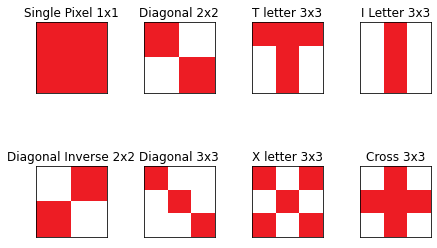

In [32]:
f, axarr = plt.subplots(2,4)
f.tight_layout(pad=0.0)
imgs=[]

for key in list(trigger_paths.keys()):
    for trigger_path in trigger_paths[key]:
        #print the trigger
        pt = os.path.join(trigger_dir, trigger_path)
        image = Image.open(pt)
        image = np.array(image)
        imgs.append(image)


axarr[0,0].imshow(imgs[0])
axarr[0,0].set_title("Single Pixel 1x1")
axarr[0,0].get_xaxis().set_ticks([])
axarr[0,0].get_yaxis().set_ticks([])
axarr[0,1].imshow(imgs[1])
axarr[0,1].set_title("Diagonal 2x2")
axarr[0,1].get_xaxis().set_ticks([])
axarr[0,1].get_yaxis().set_ticks([])
axarr[1,0].imshow(imgs[2])
axarr[1,0].set_title("Diagonal Inverse 2x2")
axarr[1,0].get_xaxis().set_ticks([])
axarr[1,0].get_yaxis().set_ticks([])
axarr[1,1].imshow(imgs[3])
axarr[1,1].set_title("Diagonal 3x3")
axarr[1,1].get_xaxis().set_ticks([])
axarr[1,1].get_yaxis().set_ticks([])
axarr[1,2].imshow(imgs[4])
axarr[1,2].set_title("X letter 3x3")
axarr[1,2].get_xaxis().set_ticks([])
axarr[1,2].get_yaxis().set_ticks([])
axarr[0,2].imshow(imgs[5])
axarr[0,2].set_title("T letter 3x3")
axarr[0,2].get_xaxis().set_ticks([])
axarr[0,2].get_yaxis().set_ticks([])
axarr[1,3].imshow(imgs[6])
axarr[1,3].set_title("Cross 3x3")
axarr[1,3].get_xaxis().set_ticks([])
axarr[1,3].get_yaxis().set_ticks([])
axarr[0,3].imshow(imgs[7])
axarr[0,3].set_title("I Letter 3x3")
axarr[0,3].get_xaxis().set_ticks([])
axarr[0,3].get_yaxis().set_ticks([])
plt.show()

Search best PP_POISON and position for each trigger

In [ ]:
#for all triggers
import sys

for key in list(trigger_paths.keys()):
    for trigger_path in trigger_paths[key]:
        #print the trigger
        pt = os.path.join(trigger_dir, trigger_path)
        image = Image.open(pt)
        image = np.array(image)
        plt.figure(figsize=(2,2))
        plt.imshow(image)
        plt.title(trigger_path)
        plt.show()

        #perform badnets attack using the trigger
        perform_badnets_grid_search(target_class,pt,key)

# BADNETS CLEAN-LABEL ATTACK USING ZOO

<b>THE FOLLOWING IS JUST EXPERIMENTAL CODE</b>

In [ ]:
import art.attacks.poisoning.backdoor_attack as BADNETS
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import to_categorical

Define attack's parameters

In [13]:
PP_POISON = 0.6
pos = [10,10]
trigger_dimension = 3
target_class = 2
trigger_path = "./files/BadNets/backdoor triggers/backdoor_trigger_3_diagonal.png"

In [29]:
def poison_dataset_clean_label(x_clean, y_clean, x_pos, indices, poison_func):
    '''
    Function to poison a dataset

    x_clean: vector of features of samples of the clean dataset
    y_clean: vector of labels of samples of the clean dataset
    x_pos: images among x_clean that have to be poisoned and added to x_clean
    y_pos: labels of x_pos
    indices: indices of x_pos among x_clean vector
    poison_func: inser_image function to insert the trigger in the image
    '''
    x_poison = np.copy(x_clean)
    is_poison = np.zeros(np.shape(y_clean)[0])

    backdoor_attack = BADNETS.PoisoningAttackBackdoor(poison_func)
    poison_images, poison_labels = backdoor_attack.poison(
        x=x_pos, y=to_categorical([target_class], 43)[0]
    )
    
    x_poison[indices]=poison_images
    is_poison[indices]=1

    is_poison = is_poison != 0

    return is_poison, x_poison

In [15]:
def backdoor_poisoning_success_rate(clf, x_poisoned, y_poisoned):
    '''
    Function to calculate success rate of the attack

    clf: classifier
    x_poisoned: features vector of poisoned validation samples
    y_poisoned: vector of target label we want to classify poisoned samples as
    '''
    
    #If the attack went good, we will have that every prediction will be wrong
    #so the success rate is 1 - the accuracy on the poisoned validation set

    success_rate=clf.evaluate(x_poisoned,y_poisoned,verbose=0)

    return 1-success_rate[1]

Define training examples that have to be poisoned

In [157]:
#get the training examples that have to be poisoned then.
imgs_to_be_poisoned = []
imgs_to_be_poisoned_labels = []

'''
for i in range(43):
    x_images_class_i=np.array(X_train[y_train==i])

    num_poison = int(x_images_class_i.shape[0]*PP_POISON)

    if num_poison:
        #take first "num_poison" indexes representing indexes of samples that are going
        #to be poisoned
        indices_to_be_poisoned=range(num_poison)

        for im in x_images_class_i[indices_to_be_poisoned]:
            imgs_to_be_poisoned.append(im)
            imgs_to_be_poisoned_labels.append(i)
'''

x_images_class_i=np.array(X_train[y_train==target_class])

num_poison = int(x_images_class_i.shape[0]*PP_POISON)

indices_poisoned=np.arange(y_train.shape[0])
indices_poisoned=np.array(indices_poisoned[y_train==target_class])[:num_poison]

if num_poison:
    #take first "num_poison" indexes representing indexes of samples that are going
    #to be poisoned
    indices_to_be_poisoned=range(num_poison)

    for im in x_images_class_i[indices_to_be_poisoned]:
        imgs_to_be_poisoned.append(im)
        imgs_to_be_poisoned_labels.append(target_class)

imgs_to_be_poisoned = np.array(imgs_to_be_poisoned)
imgs_to_be_poisoned_labels = np.array(imgs_to_be_poisoned_labels)

In [158]:
np.array(imgs_to_be_poisoned).shape

(938, 32, 32, 3)

Create adversarial examples of examples that have to be poisoned using zoo attack

In [ ]:
advs=[]

In [ ]:
#create adversarial examples from train examples that will be poisoned then.
#list which contains all adv examples

with tf.Session() as sess:
    #initialize variables (prevent FailedPreconditionError error)
    init_op = tf.initialize_all_variables()
    sess.run(init_op)
    
    model.load_weights("Model.weights_zoo.h5")
    
    mod=Modello(model)

    '''
    args={"batch_size":128,"img_resize":32,"max_iterations":6000,"print_every":1000,"switch_iterations":100,
         "init_const":0.001,"attack_type":"targeted","use_tanh":False,"lr":5e-4,"confidence":0.0}
         
    args={"batch_size":128,"img_resize":32,"max_iterations":2500,"print_every":1000,"switch_iterations":100,
         "init_const":0.001,"attack_type":"untargeted","use_tanh":False,"lr":5e-4,"confidence":0.0}
    '''
    args={"batch_size":128,"img_resize":32,"max_iterations":1500,"print_every":1000,"switch_iterations":100,
         "init_const":0.001,"attack_type":"untargeted","use_tanh":False,"lr":5e-4,"confidence":0.0}
    
    
    blackbox_attack = ZOO(sess,mod,args)

    labelss=np.zeros(43)
    labelss[target_class]=1  #one-hot encoded label
    
    count=493
    
    #cicle through all examples
    '''
    for i in np.array(imgs_to_be_poisoned)[2466:]:
    '''
    for i in np.array(imgs_to_be_poisoned)[493:]:
        print("\n\n\n",count,"\n\n\n")
        
        adv = blackbox_attack.attack(i,labelss)
                
        advs.append(adv)
        
        count=count+1
    
    advs=np.array(advs)

In [25]:
np.array(advs).shape

(909, 32, 32, 3)

In [77]:
final_advs=advs
final_advs.shape

(938, 32, 32, 3)

Save adversarial images created

In [26]:
#final_advs=advs
np.save('imgs_badnets_clean_label.npy', np.array(advs, dtype=float), allow_pickle=True)

Load adversarial images created

In [156]:
final_advs = np.load('imgs_badnets_clean_label.npy', allow_pickle=True)

Calculate zoo attack success rate and norm of difference

In [80]:
model.load_weights("Model.weights_zoo.h5")
#calculate norm and success rate
#calculate model's predictions for adversarial examples
pred_vector_adv=model.predict(final_advs)

#get predicted label
pred_labels_adv=np.array([np.argmax(p) for p in pred_vector_adv])

#get number of adv samples not predicted as stop signs
success_advs=len([p for p in pred_labels_adv if p!=target_class])

#calculate success rate
success_rate=success_advs/pred_labels_adv.shape[0]

#calculate average norm
arr_norms = np.array([LA.norm(final_advs[i].ravel()-imgs_to_be_poisoned[i].ravel(),2) for i in range(final_advs.shape[0])])
avg_norm=np.average(arr_norms)

#return difference between success rate and avg norm 
#output is maximum when avg->0 and success_rate->1

print("Success rate=",success_rate)
print("avg_norm=",avg_norm)


Success rate= 0.9989339019189766
avg_norm= 6.847330360621407


Creating poisoned validation dataset

Poisoning the entire validation dataset...
Example of posioned sample


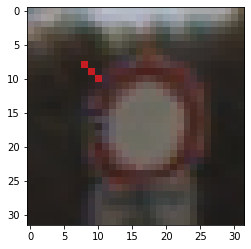

In [84]:
#adjust position pixel value based on trigger dimension
x_pos=(pos[0]-trigger_dimension+1) if (pos[0]-trigger_dimension+1)>0 else 0
y_pos=(pos[0]-trigger_dimension+1) if (pos[0]-trigger_dimension+1)>0 else 0

#initially create the poisoned validation dataset to use in order to test if the model misclassify
#unseen sampels with the trigger on them as the target class

#poison all validation dataset by adding backdoor trigger. This poisoned validation set will be used later to test the success of the attack
print("Poisoning the entire validation dataset...")
PP_POISON_VAL=1
indices = range(X_val.shape[0])
(is_poison_val,x_poisoned_val)=poison_dataset_clean_label(X_val,y_val,X_val, indices, lambda x: insert_image(x, 
                           backdoor_path=trigger_path,
                           size=(trigger_dimension,trigger_dimension),
                           mode='RGB',
                           random=False,
                           x_shift=x_pos,
                           y_shift=y_pos
                          ))

#print a validation poisoned sample
print("Example of posioned sample")
plt.figure(figsize=(4,4))
plt.imshow(x_poisoned_val[1].reshape((32,32,3)))
plt.show()

In [85]:
x_poisoned_val.shape

(11763, 32, 32, 3)

Finally poison the adversarial examples created from train examples

In [41]:
print("\n\nAttacking with position x:",x_pos," y:",y_pos,"and PP_POISON:",PP_POISON,"\n\n")
print("Poisoning training dataset...")

#poison dataset with backdoor trigger image
(is_poison_train,x_poisoned_train)=poison_dataset_clean_label(X_train,y_train,final_advs,indices_poisoned,
                    lambda x: insert_image(x, 
                       backdoor_path=trigger_path,
                       size=(trigger_dimension,trigger_dimension),
                       mode='RGB',
                       random=False,
                       x_shift=x_pos,
                       y_shift=y_pos
                      ))

print("Training dataset poisoned")



Attacking with position x: 8  y: 8 and PP_POISON: 0.6 


Poisoning training dataset...
Training dataset poisoned


Train the model with the poisoned training dataset

In [152]:
#train the model with poisoned dataset
print("Starting model train with poisoned training dataset...")
model2= tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), activation="relu",input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation="relu",input_shape=(28, 28, 32)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu",input_shape=(13, 13, 32)),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu",input_shape=(13, 13, 64)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),  #converts tensor into 1d vector
    tf.keras.layers.Dense(units=43,activation=tf.keras.activations.softmax)
])
model2.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=['accuracy'])
history=model2.fit(x_poisoned_train,y_train,batch_size=128,epochs=10,validation_data=(X_val,y_val),verbose=0)

#calculate accuracy on poisoned train and clear validation dataset
acc_train_poisoned = model2.evaluate(x_poisoned_train, y_train,verbose=0)[1]
acc_val = model2.evaluate(X_val, y_val, verbose=0)[1]

#predict labels for only validation poisoned samples in order to see if the model misclassify samples with backdoor trigger as the target class
success_rate = backdoor_poisoning_success_rate(model2, x_poisoned_val, y_val)

#calculate attack performance
performance=4*(success_rate*(1/PP_POISON)*acc_train_poisoned*acc_val)/(success_rate+(1/PP_POISON)+acc_train_poisoned+acc_val)

print("Success rate of:",success_rate, "\nWith",final_advs.shape[0],"poisoned samples used in train dataset of",X_train.shape[0],"samples")
print("Tested on",x_poisoned_val.shape[0],"validation poisoned samples")
print("poisoned validation samples created by adding the trigger on them")
print("Accuracy on poisoned training dataset:",acc_train_poisoned)
print("Accuracy on clean validation dataset:",acc_val)
print("Performace:",performance)

Starting model train with poisoned training dataset...
Success rate of: 0.006290912182266406 
With 326 poisoned samples used in train dataset of 27446 samples
Tested on 11763 validation poisoned samples
poisoned validation samples created by adding the trigger on them
Accuracy on poisoned training dataset: 0.9992712963637689
Accuracy on clean validation dataset: 0.9943891864320327
Performace: 0.011365708039965536


## CLEAN-LABEL ATTACK PROBLEM ANALYSIS

Problem analysis

Example of posioned sample


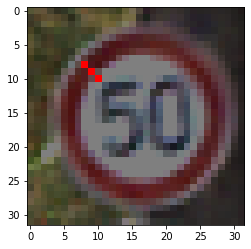

[[0.33725491 0.338411   0.21567759]
 [0.3842952  0.34104806 0.2244433 ]
 [0.39483473 0.32919014 0.23110706]
 [0.28224328 0.26095578 0.18291917]
 [0.19253924 0.18789101 0.12563844]
 [0.19467984 0.20789345 0.14133625]
 [0.25046557 0.28316289 0.18051031]
 [0.36824    0.34673163 0.22241859]
 [0.42881247 0.3258729  0.20142129]
 [0.35719526 0.3212522  0.19826984]]


In [50]:
print("Example of posioned sample")
plt.figure(figsize=(4,4))
plt.imshow(x_poisoned_train[indices_poisoned][44].reshape((32,32,3)))
plt.show()

print(x_poisoned_train[indices_poisoned][44][0][:10])

Example of posioned sample


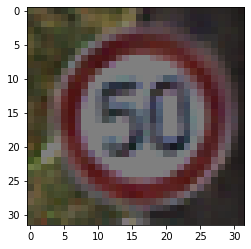

[[0.33725491 0.338411   0.21567759]
 [0.3842952  0.34104806 0.2244433 ]
 [0.39483473 0.32919014 0.23110706]
 [0.28224328 0.26095578 0.18291917]
 [0.19253924 0.18789101 0.12563844]
 [0.19467984 0.20789345 0.14133625]
 [0.25046557 0.28316289 0.18051031]
 [0.36824    0.34673163 0.22241859]
 [0.42881247 0.3258729  0.20142129]
 [0.35719526 0.3212522  0.19826984]]


In [44]:
print("Example of posioned sample")
plt.figure(figsize=(4,4))
plt.imshow(final_advs[44].reshape((32,32,3)))
plt.show()

print(final_advs[44][0][:10])

In [159]:
pred_adv = model2.predict(final_advs)
pred_adv_labels = [np.argmax(x) for x in pred_adv]

pred_poison = model2.predict(x_poisoned_train[indices_poisoned])
pred_poison_labels = [np.argmax(x) for x in pred_poison]

pred_original = model2.predict(X_train[indices_poisoned])
pred_original_labels = [np.argmax(x) for x in pred_original]

In [171]:
print("Model 2 predict ", len([x for x in pred_adv_labels if x==target_class]),"/",final_advs.shape[0],"adversarial samples as label",target_class)

Model 2 predict  789 / 938 adversarial samples as label 2


In [172]:
print("Model 2 predict ", len([x for x in pred_poison_labels if x==target_class]),"/",final_advs.shape[0],"poisoned samples as label",target_class)

Model 2 predict  936 / 938 poisoned samples as label 2


In [162]:
print("Model 2 predict ", len([x for x in pred_original_labels if x==target_class]),"/",final_advs.shape[0],"original samples as label",target_class)

Model 2 predict  933 / 938 original samples as label 2


In [48]:
def poison_dataset_clean_label_no_ART(x_clean, y_clean, x_poisoned, indices, x_pos, y_pos):
    '''
    Function to poison a dataset

    x_clean: vector of features of samples of the clean dataset
    y_clean: vector of labels of samples of the clean dataset
    x_pos: images among x_clean that have to be poisoned and added to x_clean
    y_pos: labels of x_pos
    indices: indices of x_pos among x_clean vector
    poison_func: inser_image function to insert the trigger in the image
    '''
    x_poison = np.copy(x_clean)
    is_poison = np.zeros(np.shape(y_clean)[0])

    poison_images=x_poisoned
    for i in range(indices.shape[0]):
        #set pixel "x_pos","y_pos" to red
        poison_images[i][x_pos][y_pos][0]=1
        poison_images[i][x_pos][y_pos][1]=0
        poison_images[i][x_pos][y_pos][2]=0
        
        #set pixel "x_pos+1","y_pos+1" to red
        poison_images[i][x_pos+1][y_pos+1][0]=1
        poison_images[i][x_pos+1][y_pos+1][1]=0
        poison_images[i][x_pos+1][y_pos+1][2]=0
        
        #set pixel "x_pos+2","y_pos+2" to red
        poison_images[i][x_pos+2][y_pos+2][0]=1
        poison_images[i][x_pos+2][y_pos+2][1]=0
        poison_images[i][x_pos+2][y_pos+2][2]=0
    
    x_poison[indices]=poison_images
    is_poison[indices]=1

    is_poison = is_poison != 0

    return is_poison, x_poison

In [151]:
print("\n\nAttacking with position x:",x_pos," y:",y_pos,"and PP_POISON:",PP_POISON,"\n\n")
print("Poisoning training dataset...")

#poison dataset with backdoor trigger image
(is_poison_train,x_poisoned_train)=poison_dataset_clean_label_no_ART(X_train,y_train,final_advs,indices_poisoned,x_pos,y_pos)

print("Training dataset poisoned")



Attacking with position x: 8  y: 8 and PP_POISON: 0.6 


Poisoning training dataset...
Training dataset poisoned
